In [1]:
import glob, os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from matplotlib import ticker

from chemdiskpy.constants.constants import autocm, kb, mu, amu, Ggram, M_sun
import chemdiskpy.dust as dust

## FUNCTIONS

### GETGRID

In [2]:
def get_grid():
    sizes = pd.read_table('thermal/dust_sizes.inp', engine='python', header=None) #cm
    grid = pd.read_table('thermal/amr_grid.inp', engine='python', skiprows=5) #delim_whitespace=True)

    dust_sizes = sizes[0].values

    nr = int(grid.columns[0].split('   ')[0]) #not a nice way of getting number of radii
    nt = int(grid.columns[0].split('   ')[1]) #get number of angles.
    print('number of radii: ', nr, 'number of angles: ', nt)

    radii = grid.iloc[0].str.split('    ') # get all radii
    radii = np.asarray(radii[0], dtype=float)/autocm # convert into numpy array and au
    thetas = grid.iloc[1].str.split('    ') # get all angles
    thetas = np.asarray(thetas[0], dtype=float) # convert into numpy array
    thetas[-1] = np.pi # to avoid issues with radmc3d.

    radd, tt = np.meshgrid(radii, thetas)# create grid for figure
    rr = radd*np.sin(tt)
    zz = radd*np.cos(tt)
    
    return radii, thetas, rr, zz

In [3]:
#radii, thetas, rr, zz = get_grid()
#radii

### DENSITY2D

In [143]:
def density2D(region=500, vmin=1e-30, vmax=1e0, save=False, savename='2Dmap.pdf'):
    sizes = pd.read_table('thermal/dust_sizes.inp', engine='python', header=None) #cm
    grid = pd.read_table('thermal/amr_grid.inp', engine='python', skiprows=5) #delim_whitespace=True)
    dens = pd.read_table('thermal/dust_density.inp', engine='python', header=None, skiprows=3)

    rho_m = 2.5
    mass = (4/3)*np.pi*rho_m*sizes**3
    mass = mass[0].values
    
    dust_sizes = sizes[0].values

    nr = int(grid.columns[0].split('   ')[0]) #not a nice way of getting number of radii
    nt = int(grid.columns[0].split('   ')[1]) #get number of angles.
    print('number of radii: ', nr, 'number of angles: ', nt)

    radii = grid.iloc[0].str.split('    ') # get all radii
    radii = np.asarray(radii[0], dtype=float)/autocm # convert into numpy array and au
    thetas = grid.iloc[1].str.split('    ') # get all angles
    thetas = np.asarray(thetas[0], dtype=float) # convert into numpy array
    thetas[-1] = np.pi # to avoid issues with radmc3d.

    dens = dens[0].values #to numpy
    nbspecies = int(len(dens)/(nr*nt)) # number of grain sizes
    dens = np.reshape(dens, (nbspecies, nt, nr)) # reshape the density structure.
    for i in range(0, nbspecies, 1):
        numdens = dens[i]#/mass[i]
    radii, tt = np.meshgrid(radii, thetas)# create grid for figure
    rr = radii*np.sin(tt)
    zz = radii*np.cos(tt)
    
    
    print(rr.shape, zz.shape, dens.shape)


    #--PLOT FIGURE--
    if nbspecies == 1:
        fig = plt.figure(figsize=(10, 8.))
        ax = fig.add_subplot(111)
        plt.xlabel(r'r [au]', fontsize = 17)
        plt.ylabel(r'z [au]', fontsize = 17, labelpad=-7.4)
        
        t = plt.pcolor(rr, zz, numdens, cmap='gnuplot2', shading='auto', norm=LogNorm(vmin=1e-50, vmax=1e-17))
        clr = plt.colorbar(t)
        clr.set_label(r'$n_\mathrm{d}$ [cm${-3}$]', labelpad=-33, y=1.06, rotation=0, fontsize = 16)
        #plt.pcolor(rr, zz, denstot, cmap='gnuplot2', shading='auto', norm=LogNorm(vmin=denstot.min(), vmax=denstot.max()))
        # #plt.axis([RR[:,:,0].min()/autocm, RR[:,:,0].max()/autocm, zz[:,:,0].min()/autocm, zz[:,:,0].max()/autocm])
        #ax.set_xscale('log')
        #ax.set_yscale('log')
        plt.xlim(1, region)
        plt.ylim(-region, region)
        ax.tick_params(labelsize=17)
        clr.ax.tick_params(labelsize=16) 
        #cb = plt.colorbar()
        #cb.ax.tick_params(labelsize=16)

    elif nbspecies == 4:
        fig, axs = plt.subplots(1,4, figsize=(20, 8))
        fig.tight_layout(pad=0.0)
        plt.subplots_adjust(wspace=0.0, hspace=0.0)
        for irow in range(0, 1, 1):
            for ispec in range(0, 4, 1):
                idens = ispec + irow*(1)
                axs[irow, ispec].set_xlim(1,region)
                axs[irow, ispec].set_ylim(1, region)
                numdens = dens[idens]#/mass[ispec]
                d = axs[irow, ispec].pcolormesh(rr, zz, numdens, cmap='gnuplot2', shading='auto', norm=LogNorm(vmin=1e-40, vmax=1e-15), rasterized=True)
                if irow == 0 or ispec != 0:
                    axs[irow, ispec].axes.xaxis.set_ticklabels([])
                    axs[irow, ispec].axes.yaxis.set_ticklabels([])

                props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                axs[irow, ispec].text(0.95, 0.95, r'{:0.2f} $\mu$m'.format(dust_sizes[idens]*1e4), horizontalalignment='right', verticalalignment='top', transform=axs[irow, ispec].transAxes, fontsize=15, bbox=props)
                    
        axs[1,0].tick_params(labelsize=15)
        axs[1,0].set_xlabel(r"r [au]", fontsize = 15)
        axs[1,0].set_ylabel(r"z [au]", fontsize = 15)
        fig.colorbar(d, ax=axs.ravel().tolist(), pad=0.0)

    else:
        if nbspecies == 10:
            fig, axs = plt.subplots(2,5, figsize=(20, 8))
            fig.tight_layout(pad=0.0)
            plt.subplots_adjust(wspace=0.0, hspace=0.0)
            for irow in range(0, 2, 1):
                for ispec in range(0, 5, 1):
                    idens = ispec + irow*(5)
                    axs[irow, ispec].set_xlim(1,region)
                    axs[irow, ispec].set_ylim(-region, region)
                    numdens = dens[idens]#/mass[ispec]
                    d = axs[irow, ispec].pcolormesh(rr, zz, numdens, cmap='gnuplot2', shading='auto', norm=LogNorm(vmin=vmin, vmax=vmax), rasterized=True)
                    if irow == 0 or ispec != 0:
                        axs[irow, ispec].axes.xaxis.set_ticklabels([])
                        axs[irow, ispec].axes.yaxis.set_ticklabels([])

                    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
                    axs[irow, ispec].text(0.95, 0.95, r'{:0.3f} $\mu$m'.format(dust_sizes[idens]*1e4), horizontalalignment='right', verticalalignment='top', transform=axs[irow, ispec].transAxes, fontsize=15, bbox=props)
                        
        axs[1,0].tick_params(labelsize=15)
        axs[1,0].set_xlabel(r"r [au]", fontsize = 15)
        axs[1,0].set_ylabel(r"z [au]", fontsize = 15)
        fig.colorbar(d, ax=axs.ravel().tolist(), pad=0.0)

        if save == True:
            plt.savefig('%s'%savename, dpi=150, bbox_inches="tight")

In [24]:
def density_mol2D(region=500, vmin=1e-30, vmax=1e0, save=False, species='CO', savename='2Dmap.pdf'):

    grid = pd.read_table('thermal/amr_grid.inp', engine='python', skiprows=5) #delim_whitespace=True)
    dens = pd.read_table(f'thermal/numberdens_{species}.inp', engine='python', header=None, skiprows=2)

    nr = int(grid.columns[0].split('  ')[0]) #not a nice way of getting number of radii
    nt = int(grid.columns[0].split('  ')[1]) #get number of angles.
    print('number of radii: ', nr, 'number of angles: ', nt)

    radii = grid[0:nr+1]
    radii = np.asarray(np.transpose(radii), dtype=float)[0]/autocm # convert into numpy array and au

    thetas = grid[nr+1:nr+nt+2] # get all angles
    thetas = np.asarray(np.transpose(thetas), dtype=float)[0] # convert into numpy array
    

    radii = 0.5*(radii[0:radii.size-1] + radii[1:radii.size])
    thetas = 0.5*(thetas[0:thetas.size-1] + thetas[1:thetas.size])
    thetas[-1] = np.pi # to avoid issues with radmc3d.
    thetas[0] = 0

    dens = dens[0].values #to numpy

    dens = np.reshape(dens, (nt, nr)) # reshape the density structure.

    radii, tt = np.meshgrid(radii, thetas)# create grid for figure
    rr = radii*np.sin(tt)
    zz = radii*np.cos(tt)
    
    


    fig = plt.figure(figsize=(8, 6.))
    ax = fig.add_subplot(111)
    plt.xlabel(r'r [au]', fontsize = 17)
    plt.ylabel(r'z [au]', fontsize = 17, labelpad=-7.4)
    
    t = plt.pcolormesh(rr, zz, dens, cmap='gnuplot2', shading='gouraud', norm=LogNorm(vmin=vmin, vmax=vmax))
    clr = plt.colorbar(t, pad=0.01)
    clr.set_label(r'$n_\mathrm{d}$ [cm${-3}$]', labelpad=-33, y=1.06, rotation=0, fontsize = 16)
    clr.ax.tick_params(labelsize=16) 

    plt.xlim(0, region)
    plt.ylim(-region, region)
    ax.tick_params(labelsize=17)
    
    #cb = plt.colorbar()
    #cb.ax.tick_params(labelsize=16)

    if save == True:
        plt.savefig('%s'%savename, dpi=150, bbox_inches="tight")

number of radii:  300 number of angles:  180


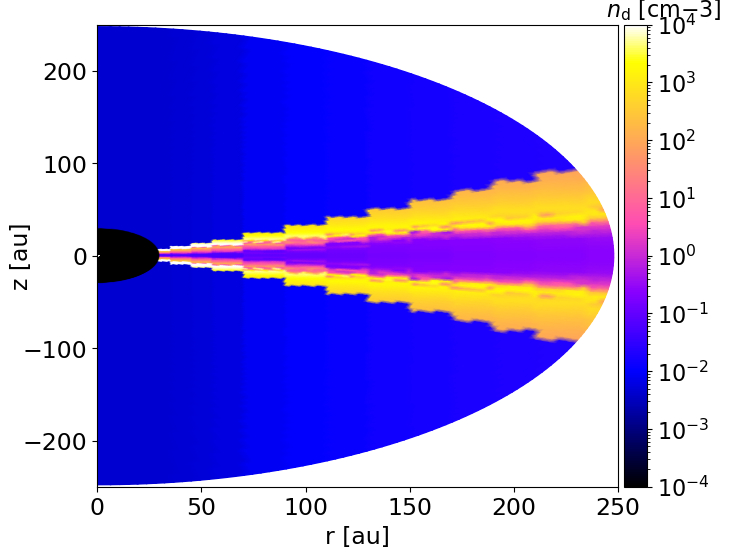

In [32]:
density_mol2D(region=250, vmin=1e-4, vmax=1e4, species='CO', save=False, savename='2Dmap.pdf')

In [40]:
1.39196e+08*1.595699E-04

22211.491800400003

### GAS-PHASE 2D MAP

In [2]:
def gasphase_multi(region=5000, iso=25, itime=59, species='CO', vmin=-15, vmax=-3, ext='', levels=[-9, -8.5, -8, -7.5, -7, -6.5, -6, -5.5, -5, -4.5, -4, -3.5], save=False, savename='results/mutli/gasphase.pdf'):
    envelope = pd.read_table('results/envelopefull{}/envelope_t{}.dat'.format(ext, str(itime)), sep=" ", engine='python')
    #snowline = pd.read_table('results/envelopefull_grain/envelopegrain_t{}.dat'.format(str(itime)), sep=" ", engine='python')

    envelope.dropna(how='all',inplace=True)
    envelope.reset_index(inplace=True)
    # snowline.dropna(how='all',inplace=True)
    # snowline.reset_index(inplace=True)
    
    nr = envelope['r'].nunique()
    nz = int(len(envelope['r'])/nr)

    z = envelope['z'].iloc[0:nz]
    r = envelope['r'].unique()
    #rr, zz = np.meshgrid(r, z)

    av = envelope['Av'].iloc[0:nz]
    rr, aav = np.meshgrid(r, av)
    z = np.reshape(envelope['z'].values, (nr, nz))
    z = np.fliplr(z)
    z = np.transpose(z)
    zz = np.flipud(z)

    
    #--SNOWLINE
    # gasCO = np.reshape(snowline['ab(CO)'].values, (nr, nz))
    # gasCO = np.transpose(gasCO)
    
    # abJ01 = np.reshape(snowline['ab(J01CO)'].values, (nr, nz))
    # abJ01 = np.transpose(abJ01)
    # abK01 = np.reshape(snowline['ab(K01CO)'].values, (nr, nz))
    # abK01 = np.transpose(abK01)
    
    # abJ02 = np.reshape(snowline['ab(J02CO)'].values, (nr, nz))
    # abJ02= np.transpose(abJ02)
    # abK02 = np.reshape(snowline['ab(K02CO)'].values, (nr, nz))
    # abK02= np.transpose(abK02)
    
    # abJ03 = np.reshape(snowline['ab(J03CO)'].values, (nr, nz))
    # abJ03 = np.transpose(abJ03)
    # abK03 = np.reshape(snowline['ab(K03CO)'].values, (nr, nz))
    # abK03 = np.transpose(abK03)
    
    # abJ04 = np.reshape(snowline['ab(J04CO)'].values, (nr, nz))
    # abJ04 = np.transpose(abJ04)
    # abK04 = np.reshape(snowline['ab(K04CO)'].values, (nr, nz))
    # abK04 = np.transpose(abK04)
    
    # abJ05 = np.reshape(snowline['ab(J05CO)'].values, (nr, nz))
    # abJ05 = np.transpose(abJ05)
    # abK05 = np.reshape(snowline['ab(K05CO)'].values, (nr, nz))
    # abK05 = np.transpose(abK05)
    
    # abJ06 = np.reshape(snowline['ab(J06CO)'].values, (nr, nz))
    # abJ06 = np.transpose(abJ06)
    # abK06 = np.reshape(snowline['ab(K06CO)'].values, (nr, nz))
    # abK06 = np.transpose(abK06)
    
    # abJ07 = np.reshape(snowline['ab(J07CO)'].values, (nr, nz))
    # abJ07 = np.transpose(abJ07)
    # abK07 = np.reshape(snowline['ab(K07CO)'].values, (nr, nz))
    # abK07 = np.transpose(abK07)
    
    # abJ08 = np.reshape(snowline['ab(J08CO)'].values, (nr, nz))
    # abJ08 = np.transpose(abJ08)
    # abK08 = np.reshape(snowline['ab(K08CO)'].values, (nr, nz))
    # abK08 = np.transpose(abK08)
    
    # abJ09 = np.reshape(snowline['ab(J09CO)'].values, (nr, nz))
    # abJ09 = np.transpose(abJ09)
    # abK09 = np.reshape(snowline['ab(K09CO)'].values, (nr, nz))
    # abK09 = np.transpose(abK09)
    
    # abJ10 = np.reshape(snowline['ab(J10CO)'].values, (nr, nz))
    # abJ10 = np.transpose(abJ10)
    # abK10 = np.reshape(snowline['ab(K10CO)'].values, (nr, nz))
    # abK10 = np.transpose(abK10)
    
    # coline_tot = gasCO/(gasCO + (abJ01+abK01)+(abJ02+abK02)+(abJ03+abK03)+(abJ04+abK04)+(abJ05+abK05)+(abJ06+abK06)+(abJ07+abK07)+(abJ08+abK08)+(abJ09+abK09)+(abJ10+abK10))
    #----


    nH = np.reshape(envelope['nH'].values, (nr, nz))
    nH = np.transpose(nH)
    ab = np.reshape(envelope['ab({})'.format(species)].values, (nr, nz))
    ab = np.transpose(ab)

    map2D = np.reshape(envelope['nH'].values, (nr, nz))
    map2D = np.transpose(map2D)

    Td = np.reshape(envelope['Td'].values, (nr, nz))
    Td = np.transpose(Td)

    Td1 = np.reshape(envelope['Td1'].values, (nr, nz))
    Td1 = np.transpose(Td1)
    Td2 = np.reshape(envelope['Td2'].values, (nr, nz))
    Td2 = np.transpose(Td2)
    Td3 = np.reshape(envelope['Td3'].values, (nr, nz))
    Td3 = np.transpose(Td3)
    Td4 = np.reshape(envelope['Td4'].values, (nr, nz))
    Td4 = np.transpose(Td4)
    Td5 = np.reshape(envelope['Td5'].values, (nr, nz))
    Td5 = np.transpose(Td5)
    Td6 = np.reshape(envelope['Td6'].values, (nr, nz))
    Td6 = np.transpose(Td6)
    Td7 = np.reshape(envelope['Td7'].values, (nr, nz))
    Td7 = np.transpose(Td7)
    Td8 = np.reshape(envelope['Td8'].values, (nr, nz))
    Td8 = np.transpose(Td8)
    Td9 = np.reshape(envelope['Td9'].values, (nr, nz))
    Td9 = np.transpose(Td9)
    Td10 = np.reshape(envelope['Td10'].values, (nr, nz))
    Td10 = np.transpose(Td10)

    #CAVITY
    z0 = 150
    phi = (45*np.pi)/180
    zcav = z0*(r/(z0*np.tan(phi/2)))**1.5
    zmax = np.where(zz >= zcav)

    fig = plt.figure(figsize=(8, 7.2))
    ax = fig.add_subplot(111)

    ax.set_xlabel(r'r [au]', fontsize = 20)
    ax.set_ylabel(r'z [au]', fontsize = 20)
    logab = np.log10(ab)
    #t = plt.pcolormesh(rr, zz, map2D, cmap='gnuplot2', shading='gouraud', vmin=np.min(map2D), vmax=np.max(map2D), rasterized=True)
    #t = plt.pcolormesh(rr, zz, logab, cmap='rainbow', shading='gouraud', vmin=vmin, vmax=vmax, rasterized=True) #norm=LogNorm(vmin=np.min(logab), vmax=np.max(logab))
    t = plt.contourf(rr, zz, logab, cmap='rainbow', levels=levels, extend='both') #levels=[-14, -13, -12, -11, -10, -9, -8, -7, -6, -5, -4, -3] #locator=ticker.AutoLocator() #levels=[-13, -12, -11, -10, -9, -8]
    #clr = plt.colorbar(t)
    clr = plt.colorbar(t, pad=0.01)
    clr.ax.tick_params(labelsize=16)
    clr.set_label(r'log$_{10}$ X(%s)' %species, labelpad=0, y=0.5, rotation=90, fontsize = 15)

    props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)
    
    #plt.contour(rr, zz, coline_tot, [0.5], colors='white', linewidths=4.5)

    # plt.contour(rr, zz, Td1, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td2, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td3, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td4, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td5, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td6, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td7, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td8, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td9, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td10, [iso], linewidths=1.5, colors='black', zorder=1)
    # plt.contour(rr, zz, Td, [iso], linewidths=3.5, colors='gray')

    plt.plot(r, zcav, lw=3.5, c='white', zorder=1)
    ax.fill_between(r, zcav, zcav+1e5, color='white', alpha=1, zorder=1)
    ax.set_xlim(15, region) 
    ax.set_ylim(0.1, region) 
    ax.tick_params(labelsize=17)
    
    if save == True:
        plt.savefig('%s'%savename, dpi=150, bbox_inches="tight")


In [6]:
# lev=[-9.5, -8.5, -7.5, -6.5, -5.5, -4.5, -3.5]
# #lev=[-12,-11,-10,-9,-8,-7,-6,-5, -4.5]
# lev=[-12,-11,-10,-9,-8,-7,-6,-5]
# gasphase_multi(region=600, iso=22, itime=20, species='H2O', vmin=-9, vmax=-4, ext='_zoom_mol', levels=lev, save=False, savename='results/figures/shark_H2Ogasphase_zoom_atomic.pdf')

### MIDPLANE_TEMP

In [14]:
def midplane_temp(angle=50, maxtemp=60, xlim=300, ext=''):
    #import chemdiskpy.modeling as modeling
    #m = modeling.Structure()  

    #-----DISK PARAMETERS
    nr, ntheta, nphi = 301, 181, 2
    rin, rout= 1, 500
    dtogas = 1e-2
    star_mass = 1.
    dust_mass = 7.5e-5
    q_c = 12
    #-------------------

    #-----SNOWLINE
    element = 'CO'
    Eb = 1.1*1150 #K
    S = 0.9
    kb = 1.38054e-16 #erg.K-1
    nsite = 8.000E+14 #cm-2
    ratio_gs = 1

    sizes = pd.read_table('thermal/dust_sizes.inp', engine='python', header=None) #cm
    sizes = sizes*1e4

    grid = pd.read_table('thermal/amr_grid.inp', engine='python', skiprows=5)
    nr = int(grid.columns[0].split('   ')[0]) #not a nice way of getting number of radii
    nt = int(grid.columns[0].split('   ')[1]) #get number of angles.
    print(nr, nt)
    dist = grid.iloc[0].str.split('    ') # get all radii
    dist_au = np.asarray(dist[0], dtype=float)/autocm # convert into numpy array and au
    dist = np.asarray(dist[0], dtype=float)

    thetas = grid.iloc[1].str.split('    ')
    thetas = np.asarray(thetas[0], dtype=float) # convert into numpy array
    thetas[-1] = np.pi
    dist, tt = np.meshgrid(dist, thetas)
    rr = dist*np.sin(tt)
    zz = dist*np.cos(tt)
    radii = 0.5*(rr[50][0:rr[50].size-1] + rr[50][1:rr[50].size])

    temperature = pd.read_table('thermal/dust_temperature{}.dat'.format(ext), engine='python', header=None, skiprows=3)
    temp = temperature[0].values
    nbspecies = int(len(temperature)/(nr*nt))
    temp = np.reshape(temp, (nbspecies, nt, nr))
    midtemp = temp[:, angle, :]

    fig = plt.figure(figsize=(9.6, 8.2))
    ax = fig.add_subplot(111)

    #-----profiles
    lwsmall = 1.2
    lwlarge = 1.2
    midtemp = pd.DataFrame(data=midtemp.transpose())

    for ispec in range(0, nbspecies):
        if sizes[0].iloc[ispec] < 10:
            #lwsmall += 0.2
            ax.plot(radii/autocm, midtemp[ispec].rolling(window=4, center=True).mean(), linewidth=lwsmall, linestyle=':', label='bin {}'.format(ispec+1))
        else:
            #lwlarge += 0.2
            ax.plot(radii/autocm, midtemp[ispec].rolling(window=4, center=True).mean(), linewidth=lwlarge, linestyle='-', label='bin {}'.format(ispec+1))
    
    ax.hlines(20,0, 5000, color='black')
    ax.set_ylim(5,maxtemp)
    ax.set_xlim(1,xlim)
    ax.set_xlabel(r'r [au]', fontsize = 20)
    ax.set_ylabel(r'T [K]', fontsize = 20)
    ax.legend(fontsize=15)
    ax.tick_params(labelsize=18)
    plt.show()

In [66]:
def viscous_heating_2D(region=500, vmin=1e-30):
    grid = pd.read_table('thermal/amr_grid.inp', engine='python', skiprows=5)
    q_visc = pd.read_table('thermal/heatsource.inp', engine='python', header=None, skiprows=2)
    

    nr = int(grid.columns[0].split('   ')[0]) #not a nice way of getting number of radii
    nt = int(grid.columns[0].split('   ')[1]) #get number of angles.
    print(nr, nt)
    dist = grid.iloc[0].str.split('    ') # get all radii
    dist_au = np.asarray(dist[0], dtype=float)/autocm # convert into numpy array and au
    dist = np.asarray(dist[0], dtype=float)

    thetas = grid.iloc[1].str.split('    ')
    thetas = np.asarray(thetas[0], dtype=float) # convert into numpy array
    thetas[-1] = np.pi
    dist, tt = np.meshgrid(dist_au, thetas)
    rr = dist*np.sin(tt)
    zz = dist*np.cos(tt)
    
    q_visc = q_visc[0].values
    q_visc = np.reshape(q_visc, (nt, nr))

    print(np.min(q_visc), np.max(q_visc))
    fig = plt.figure(figsize=(10, 8.))
    ax = fig.add_subplot(111)
    plt.xlabel(r'r [au]', fontsize = 17)
    plt.ylabel(r'z [au]', fontsize = 17, labelpad=-7.4)
    t = plt.pcolor(rr, zz, q_visc, cmap='hot', shading='auto', norm=LogNorm(vmin=vmin, vmax=np.max(q_visc)))
    clr = plt.colorbar(t)
    clr.set_label(r'$n_\mathrm{d}$ [cm${-3}$]', labelpad=-33, y=1.06, rotation=0, fontsize = 16)
    plt.xlim(1, region)
    plt.ylim(-region/2, region/2)
    ax.tick_params(labelsize=17)
    clr.ax.tick_params(labelsize=16) 

## SHOW IMAGE

In [102]:
def show_image(path='thermal/', distance=160, cmap='turbo', vmin=1e-20, vmax=5e-14, widthkms=65, L=5, wave='_1300', ext='', save=True, savename='image.pdf'):
    from astropy import units as u
    from astropy.visualization import (MinMaxInterval, SqrtStretch,SinhStretch,PowerStretch,LogStretch,AsinhStretch,
                                   ImageNormalize)
    
    d_au = u.pc.to(u.au, distance)
    #--get data
    filename = path + "image{}{}.out".format(wave, ext)
    f = open(filename,"r")
    f.readline()
    im_nx, im_ny = [int(x) for x in f.readline().split()]
    nlam = int(f.readline())
    pixsize_x, pixsize_y = [float(x) for x in f.readline().split()]
    for i in range(0, nlam):
        float(f.readline())

    f.readline()

    print(2*im_nx*im_ny ,pixsize_x, pixsize_y)

    image = np.empty((nlam*im_nx*im_ny,))

    #read data
    for k in range(0, nlam):
        for j in range(k*im_nx*im_ny, (k+1)*im_nx*im_ny): #avoid empty lines every im_nx*im_ny lines
            image[j] = float(f.readline())
        f.readline()

    f.close()
    #-----------



    
    #pixsize_x_arcsec = 3600*((pixsize_x/autocm/d_au)*180)/np.pi
    #pixsize_y_arcsec = 3600*((pixsize_y/autocm/d_au)*180)/np.pi

    pixsize_x_arcsec = ((pixsize_x/autocm/distance))
    pixsize_y_arcsec = ((pixsize_y/autocm/distance))
    print(im_nx, im_ny ,pixsize_x_arcsec, pixsize_y_arcsec)

    pixsize_deg = ((pixsize_x/autocm/d_au)*180)/np.pi

    convJy = 1e3*((pixsize_deg*(np.pi/180.))*(pixsize_deg*(np.pi/180.))) * 1.e23

    x = np.linspace(-(im_nx*pixsize_x_arcsec)/2, +(im_nx*pixsize_x_arcsec)/2, im_nx)
    y = np.linspace(-(im_ny*pixsize_y_arcsec)/2, +(im_ny*pixsize_y_arcsec)/2, im_nx) #arcsec
    #x = np.linspace(-(im_nx*pixsize_x)/autocm/2, +(im_nx*pixsize_x)/autocm/2, im_nx)
    #y = np.linspace(-(im_ny*pixsize_y)/autocm/2, +(im_ny*pixsize_y)/autocm/2, im_ny) # au
    xx, yy = np.meshgrid(x, y)
    xx, yy = np.meshgrid(np.arange(0,im_nx,1), np.arange(0,im_ny,1))
    image = np.reshape(image, (nlam, im_nx, im_ny))
    print(image.shape)

    kms = np.linspace(-widthkms, widthkms, nlam)
    delta_kms = kms[-1]-kms[-2]
    mom0 = np.zeros((im_nx, im_ny))
    for k in range(0, nlam):
        mom0 += image[k, :, :]
    mom0 = mom0*delta_kms*1e23*4*np.pi # convert to jansky: 1Jy = 10-23 erg s-1  cm-2 Hz-1
    image = image*1e23*4*np.pi

    #----PLOT----
    fig = plt.figure(figsize=(10, 8.))
    ax = fig.add_subplot(111)
    plt.xlabel(r"$\Delta$ RA [pix]", fontsize = 17)
    plt.ylabel(r"$\Delta$ DEC [pix]", fontsize = 17, labelpad=0)
    #norm2 = ImageNormalize(image*convJy, vmin=0.0001, vmax=np.max(image*convJy))
    t = plt.pcolormesh(xx, yy, mom0, cmap=cmap, shading='gouraud', norm=LogNorm(vmin=vmin, vmax=vmax), rasterized=True) #norm=norm2) #continuum
    #t = plt.pcolormesh(xx, yy, image[5, :, :], cmap=cmap, shading='gouraud', norm=LogNorm(vmin=vmin, vmax=vmax)) #norm=norm2)
    clr = plt.colorbar(t, pad=0.01)
    #clr.set_label(r'I [mJy/pixel]', x=1, y=0.5, rotation=90, fontsize = 14)
    clr.set_label(r'I [Jy km s-1]', x=1, y=0.5, rotation=90, fontsize = 14)
    clr.ax.tick_params(labelsize=14) 
    plt.xlim(0, 600)
    plt.ylim(0, 600)
    # plt.xlim(-(im_nx*pixsize_x_arcsec)/2, (im_nx*pixsize_x_arcsec)/2)
    # plt.ylim(-(im_ny*pixsize_y_arcsec)/2, (im_ny*pixsize_y_arcsec)/2)
    #plt.xlim(-(im_nx*pixsize_x)/autocm/2, (im_nx*pixsize_x)/autocm/2)
    #plt.ylim(-(im_ny*pixsize_y)/autocm/2, (im_ny*pixsize_y)/autocm/2)
    ax.tick_params(labelsize=15)
    #draw_scalebar(ax, distance, L, barwidth=0.01, color='white')

    if save == True:
        plt.savefig('%s'%savename, dpi=150, bbox_inches="tight")

In [7]:
#show_image(path='thermal/', distance=160, widthkms=65, cmap='gnuplot',  vmin=7e8, vmax=2e12, L=5, wave='_N2H+_1-0', ext='_incl90', save=False, savename='results/figures/image_N2H+_incl90_shark.pdf')

In [2]:
def static(column='nH', vmin= 1, vmax=50, iso=25, region=4800, prefix='', save=False, savename='filename.pdf'):

    # rin = np.arange(15, 150, 2)
    # rmid = np.arange(200, 1500, 50)
    # rmid2 = np.arange(1500, 2000, 100)
    # rout = np.arange(2000, 5000, 200)
    # rchem = np.concatenate((rin, rmid, rmid2, rout), axis=0)

    rin = np.arange(5, 500, 5)
    rout = np.arange(500, 650, 50)
    rchem = np.concatenate((rin, rout), axis=0)
    
    nbz = 90


    line = np.arange(0, nbz, 1)
    
    rr, tt = np.meshgrid(rchem, line)

    static_map = np.zeros((nbz, len(rchem)))
    temp_map = np.zeros((nbz, len(rchem)))
    uv_map = np.zeros((nbz, len(rchem)))
    zz = np.zeros((nbz, len(rchem)))
    columns = ['z', 'nH', 'Tg', 'Av', 'diff', 'Td', 'inv_ab', 'conv_factor', 'a', 'uv']

    for idx, r in enumerate(rchem):
        path = 'chemistry' + prefix + '/' + str(int(r)) + 'AU/'
        static = pd.read_table(path+'1D_static.dat', sep="   ", comment='!', header=None, engine='python')
        static.columns = columns
        static_map[:, idx] = static[column].values
        temp_map[:, idx] = static['Td'].values
        uv_map[:, idx] = static['uv'].values
        zz[:, idx] = static['z'].values
    
    # alpha = 2.6e-10 #CO
    # gamma = 3.53
    # photorate = alpha*static_map*np.exp(-gamma*av_map)
    
    #CAVITY
    r = rchem
    z0 = 150
    phi = (37*np.pi)/180
    zcav = z0*(r/(z0*np.tan(phi/2)))**1.5
    zmax = np.where(zz >= zcav)

    fig,ax = plt.subplots(figsize=(6,6))
    ax.set_aspect('equal', adjustable='box')
    plt.xlabel(r'r [au]', fontsize = 20)
    plt.ylabel(r'z [au]', fontsize = 20)
    #t = plt.pcolormesh(rr, zz, np.flip(photorate, axis=0), cmap='gnuplot2', shading='gouraud', norm=LogNorm(vmin=np.min(photorate), vmax=np.max(photorate)))
    t = plt.pcolormesh(rr, zz, static_map, cmap='gnuplot2', shading='auto', norm=LogNorm(vmin=vmin, vmax=vmax), rasterized=True)
    clr = plt.colorbar(t, pad=0.01)
    #plt.contour(rr, zz, static_map, [10, 15, 20, 25, 30], colors='grey', linewidths=2.5)
    plt.contour(rr, zz, temp_map, [iso], colors='black', linewidths=2.5)
    
    plt.plot(r, zcav, lw=2.5, c='gray', zorder=3)
    #ax.fill_between(r, zcav, zcav+1e5, color='white', alpha=1, zorder=2)

    ax.tick_params(labelsize=15)
    #clr.ax.tick_params(labelsize=16) #temperature
    ax.set_xlim(5, region)
    ax.set_ylim(0.1, region)

    if save == True:
        plt.savefig('%s'%savename, dpi=150, bbox_inches="tight")

______

In [8]:
#static(column='Av', vmin=1e0, vmax=4e2, iso=150, region=600, prefix='_zoom_mol', save=False, savename='results/figures/multi/av_init.pdf')

____

___

In [9]:
#midplane_temp(angle=97, maxtemp=70, xlim=1000, ext='_original')